<a href="https://colab.research.google.com/github/PiotMik/spread-options/blob/feature%2FNotebook_Copulas/Copulas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bivariate copulas for crack spread option pricing


In [62]:
! pip install copulas

In [121]:
import copulas as cp

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.covariance import EllipticEnvelope
from scipy.stats import norm, linregress

from statsmodels.graphics import tsaplots

from google.colab import files
sns.set()
plt.rcParams['figure.figsize'] = (14, 7)

In [4]:
uploaded = files.upload()

Saving CO.csv to CO.csv
Saving HO.csv to HO.csv


---

## Data
Dane pochodzą z https://www.macrotrends.net/.
Ściągnęliśmy kilka lat dziennych obserwacji:
* [Closing price for No. 2 Heating Oil: New York Harbor](https://www.macrotrends.net/2479/heating-oil-prices-historical-chart-data). The prices shown are in U.S. dollars.
* [West Texas Intermediate (WTI or NYMEX) crude oil prices per barrel](https://www.macrotrends.net/1369/crude-oil-price-history-chart). The price of oil shown is adjusted for inflation using the headline CPI and is shown by default on a logarithmic scale

In [6]:
ho_df = pd.read_csv('HO.csv', skiprows=13, index_col='date', parse_dates=True)
co_df = pd.read_csv('CO.csv', skiprows=13, index_col='date', parse_dates=True)

ho_df = ho_df.rename(columns={" value": "HeatingOil"})
ho_df.HeatingOil = ho_df.HeatingOil*42
co_df = co_df.rename(columns={" value": "CrudeOil"})

spread_df = pd.DataFrame(ho_df.HeatingOil - co_df.CrudeOil)
spread_df = spread_df.rename(columns={0: "Spread"})

pricing_df = pd.concat([ho_df, co_df, spread_df], axis=1)
pricing_df.head()

,HeatingOil,CrudeOil,Spread
date,,,
2008-12-29,53.76,39.89,13.87
2008-12-30,53.76,38.95,14.81
2008-12-31,55.02,44.60,10.42
2009-01-02,61.32,46.17,15.15
2009-01-05,65.10,48.61,16.49


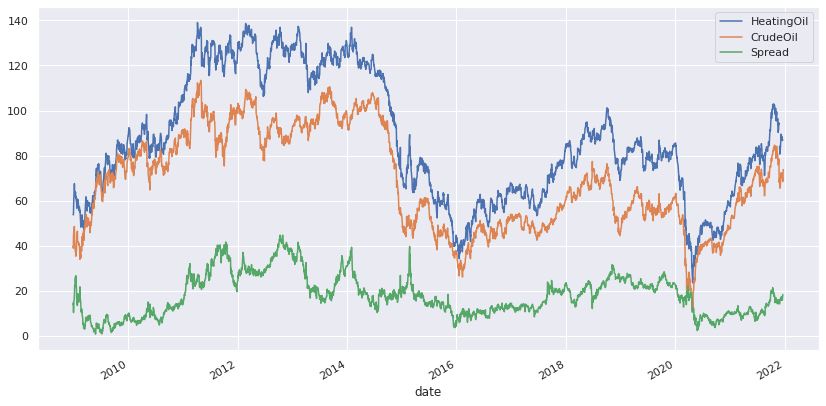

In [7]:
pricing_df.plot()

---

## Logreturns analysis

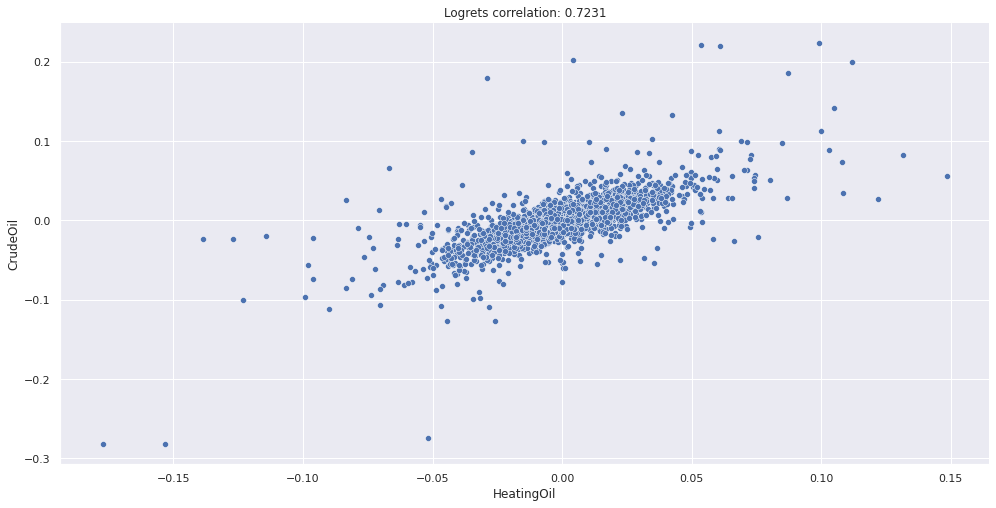

In [8]:
logrets_df = np.log(pricing_df).diff().dropna()
sns.relplot(data = logrets_df, x="HeatingOil", y="CrudeOil", height = 7, aspect=2)
corr = logrets_df.loc[:, ["HeatingOil", "CrudeOil"]].corr().iloc[1, 0]
_=plt.title(f"Logrets correlation: {corr:.4f}")

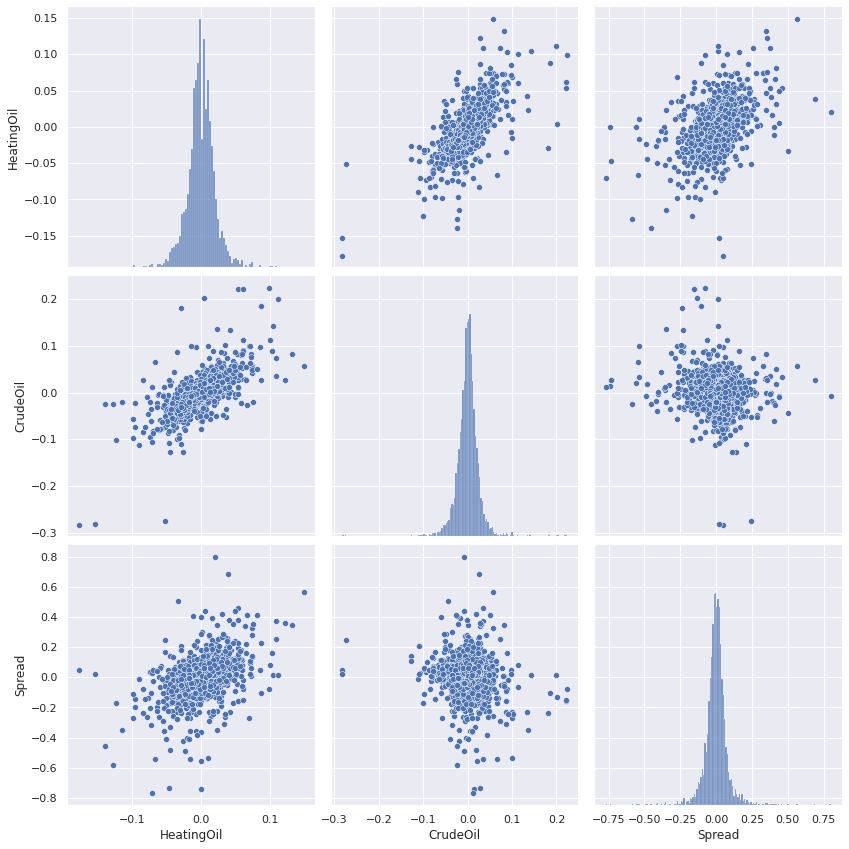

In [18]:
_ = sns.pairplot(logrets_df, height=4, aspect=1)

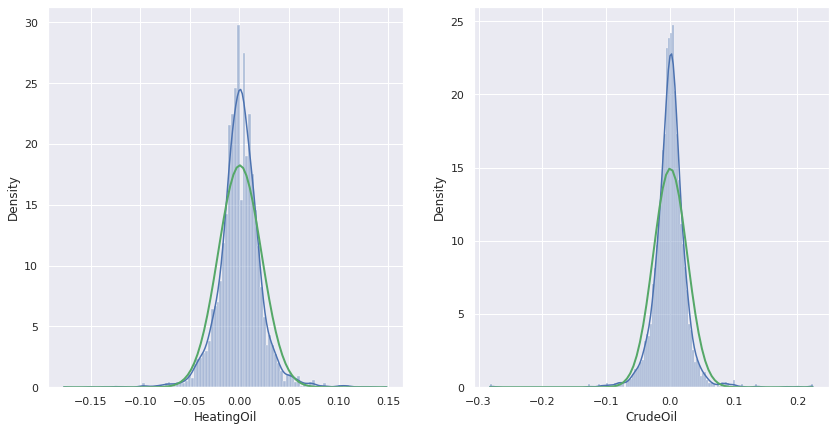

In [19]:
def plot_norm_fit(axes, data):
  xmin, xmax = data.min(), data.max()
  x = np.linspace(xmin, xmax, 100)
  fit = norm.fit(data)
  p = norm.pdf(x, *fit)
  axes.plot(x, p, 'g', linewidth=2)
  
fig, ax = plt.subplots(1, 2)
norm_fits = [norm.fit(data) for data in [logrets_df.HeatingOil, logrets_df.CrudeOil]]
sns.histplot(logrets_df.HeatingOil, alpha=0.4, kde=True, stat='density', ax = ax[0])
plot_norm_fit(ax[0], logrets_df.HeatingOil)

sns.histplot(logrets_df.CrudeOil, alpha=0.4, kde =True, stat='density', ax = ax[1])
plot_norm_fit(ax[1], logrets_df.CrudeOil)

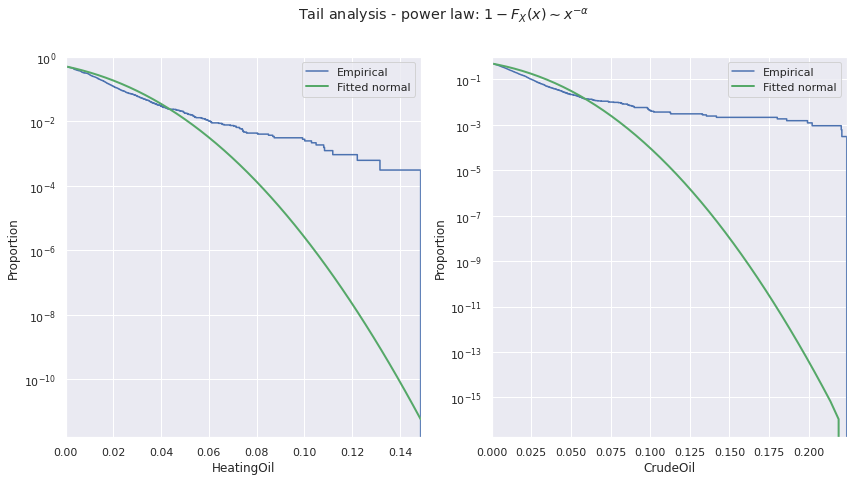

In [43]:
def plot_fit_survival(axes, data):
  xmin, xmax = data.min(), data.max()
  x = np.linspace(xmin, xmax, 100)
  fit = norm.fit(data)
  p = 1 - norm.cdf(x, *fit)
  axes.plot(x, p, 'g', linewidth=2, label='Fitted normal')

fig, ax = plt.subplots(1, 2)
logscale = True

sns.ecdfplot(logrets_df.HeatingOil, ax = ax[0], complementary=True, label='Empirical')
plot_fit_survival(ax[0], logrets_df.HeatingOil)
ax[0].set_xlim(0, logrets_df.HeatingOil.max())

sns.ecdfplot(logrets_df.CrudeOil, ax = ax[1], complementary=True, label = 'Empirical')
plot_fit_survival(ax[1], logrets_df.CrudeOil)
ax[1].set_xlim(0, logrets_df.CrudeOil.max())

if logscale:
  ax[1].set_yscale('log')
  ax[0].set_yscale('log')
  plt.suptitle(r'Tail analysis - power law: $ 1-F_X(x)\sim x^{- \alpha } $')
else:
  ax[0].set_ylim(0, 0.5)
  ax[1].set_ylim(0, 0.5)
  plt.suptitle("Tail analysis")
  
ax[0].legend()
ax[1].legend()

---

## Copulas (theory)

### Formalna definicja


> Dwuwymiarową kopułą nazywamy funkcję:
> $C: [0, 1]^2 \rightarrow \mathbb{R}, $
> spełniającą warunki:
> * $C(u, 0) = C(0, v) = 0$ (grounded)
> * $C(u, 1) = u \wedge C(1, v)=v$ 
> * $2$-rosnąca

Oznaczmy przez $F_{XY}$ dystrybuantę rozkładu łącznego, $F_X(x)$, $F_Y(y)$ rozkłady brzegowe. Wtedy istnieje dwuwymiarowa kopuła $C$, taka że: 

$$F_{XY}(x, y) = C(F_X(x), F_Y(y)).$$ 

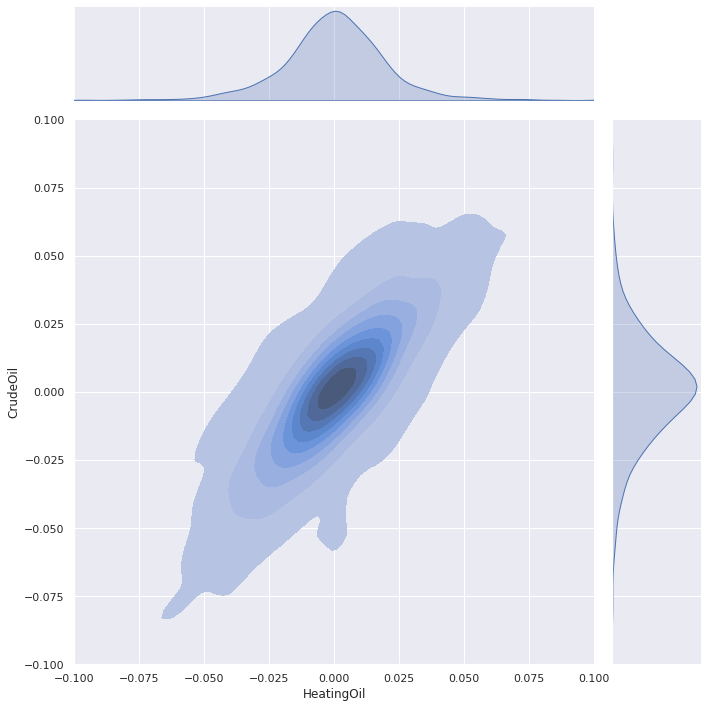

In [94]:
_=sns.jointplot(
    data=logrets_df,
    x="HeatingOil", y="CrudeOil",
    height=10, kind="kde", 
    fill=True, xlim=(-0.1, 0.1), ylim=(-0.1, 0.1))

Text(0.5, 0.98, 'Empirical CDFs')

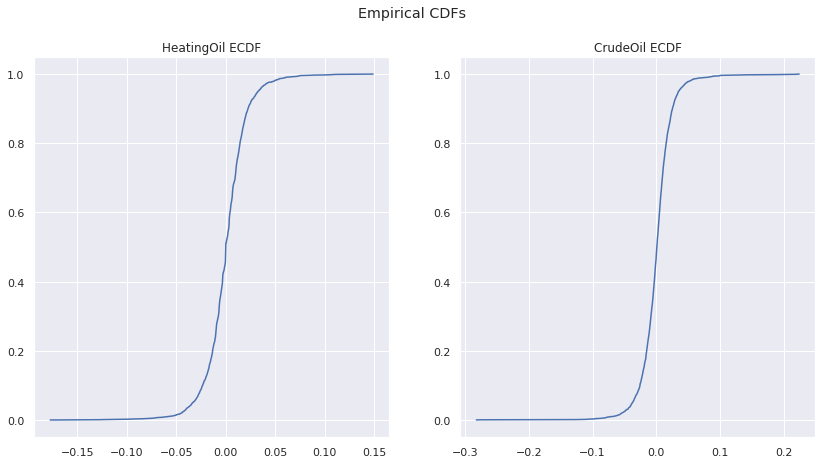

In [95]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdfs = {asset: ECDF(logrets_df[asset]) for asset in ['HeatingOil', 'CrudeOil']}

fig, ax = plt.subplots(1, 2)

for ind, asset in enumerate(['HeatingOil', 'CrudeOil']):
  x = logrets_df[asset].sort_values()
  ax[ind].plot(x, ecdfs[asset](x))
  ax[ind].set_title(f"{asset} ECDF")

plt.suptitle("Empirical CDFs")

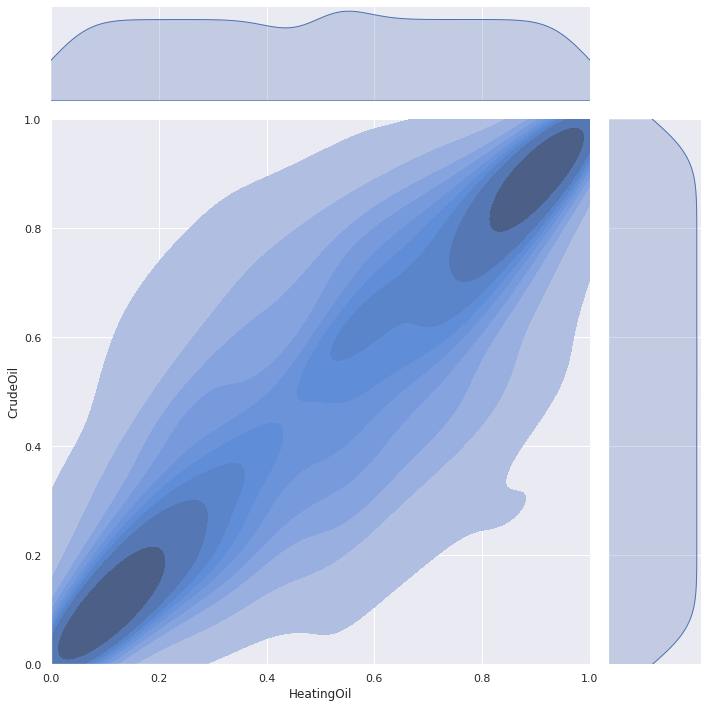

In [157]:
logrets_u_df = logrets_df.iloc[:, 0:2].copy()
for ind, asset in enumerate(['HeatingOil', 'CrudeOil']):
  logrets_u_df[asset] = ecdfs[asset](logrets_df[asset])

_=sns.jointplot(
    data=logrets_u_df,
    x="HeatingOil", y="CrudeOil",
    height=10, kind="kde", 
    fill=True, xlim=(0, 1), ylim=(0, 1))

In [150]:
from copulas.bivariate.clayton import Clayton
from copulas.bivariate.gumbel import Gumbel
from copulas.bivariate.frank import Frank
from copulas.bivariate.independence import Independence

In [174]:
cop = Gumbel()
cop.fit(logrets_u_df.to_numpy())

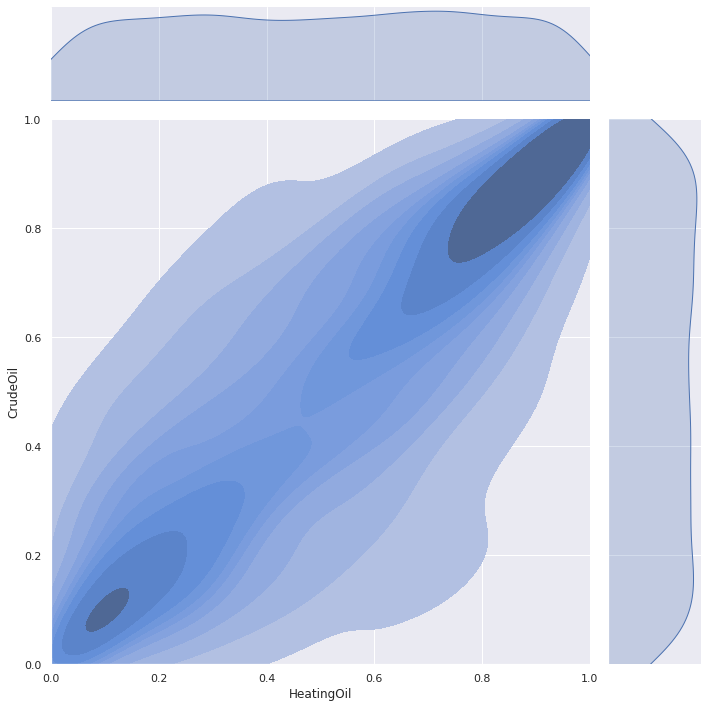

In [175]:
data = pd.DataFrame(cop.sample(3000), columns = ["HeatingOil", "CrudeOil"])
_=sns.jointplot(
    data=data,
    x="HeatingOil", y="CrudeOil",
    height=10, kind="kde", 
    fill=True, xlim=(0, 1), ylim=(0, 1))

## Time Series Analysis of marginals

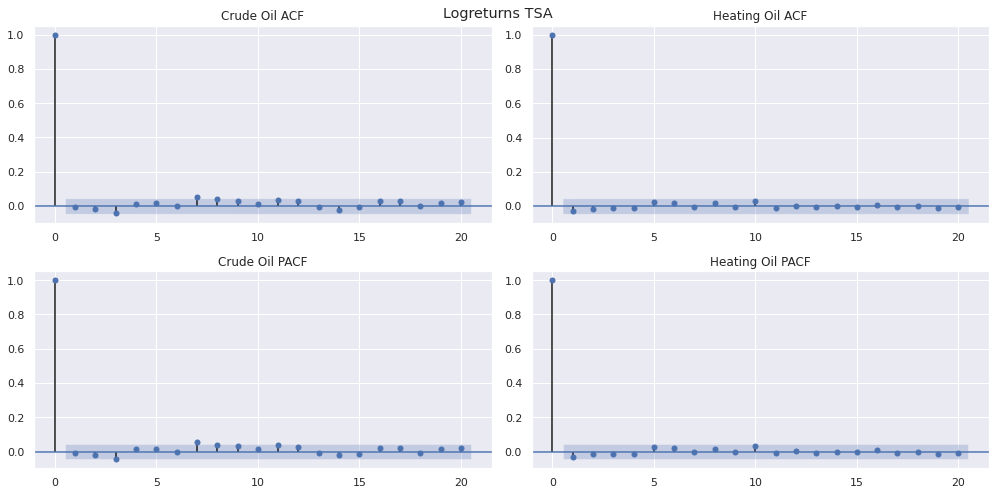

In [98]:
fig, ax = plt.subplots(2, 2)

zero=True
_ = tsaplots.plot_acf(logrets_df.CrudeOil, title="Crude Oil ACF", ax = ax[0][0], zero=zero, alpha=0.01, lags=20)
_ = tsaplots.plot_pacf(logrets_df.CrudeOil, title="Crude Oil PACF", ax = ax[1][0], zero=zero, alpha = 0.01, lags=20)

_ = tsaplots.plot_acf(logrets_df.HeatingOil, title="Heating Oil ACF", ax = ax[0][1], zero=zero, alpha = 0.01, lags=20)
_ = tsaplots.plot_pacf(logrets_df.HeatingOil, title="Heating Oil PACF", ax = ax[1][1], zero=zero, alpha =0.01, lags = 20)

plt.suptitle("Logreturns TSA")
plt.tight_layout()